# Structural Estimation HW2 
## Takuya Ando 

## Question1

(a)First, load necessary packages.

In [545]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
import scipy.stats as sts
import math
import scipy.special as spc
from sympy import Symbol,solve,exp
from scipy import integrate

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

Load data.

In [546]:
clms = pd.read_csv("clms.txt", header=None)
clms.columns = ["health_expenditure"]

Mean, median, max and minimum values are as below.

In [547]:
print("mean: ", np.mean(clms))

mean:  health_expenditure    720.277975
dtype: float64


In [548]:
print("median: ", np.median(clms))

median:  172.21


In [549]:
print("max: ", np.max(clms))

max:  health_expenditure    227967.25
dtype: float64


In [550]:
print("min: ", np.min(clms))

min:  health_expenditure    0.01
dtype: float64


The histogram for uncensored data is as below. Because of the outliers, the plot seems hard to read.

Text(0, 0.5, 'Frequency of observations')

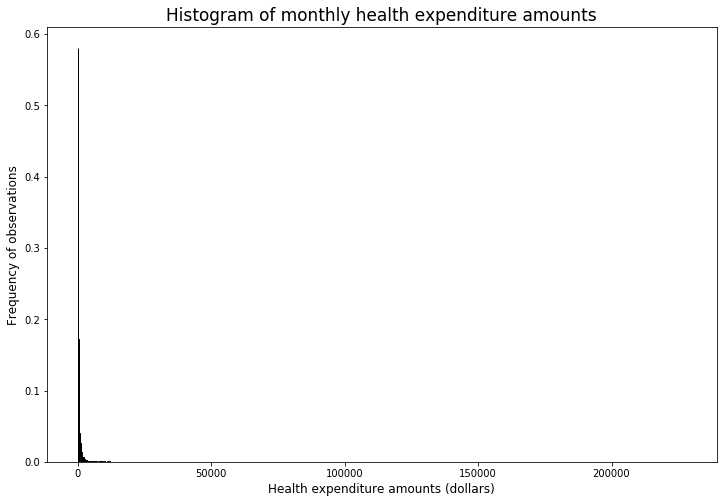

In [551]:
plt.figure(figsize=(12, 8))

weights = (1 / clms.shape[0]) * np.ones_like(clms)

plt.hist(clms["health_expenditure"], bins=1000, weights=weights, edgecolor="k")
plt.title('Histogram of monthly health expenditure amounts', fontsize=17)
plt.xlabel(r'Health expenditure amounts (dollars)', fontsize=12)
plt.ylabel(r'Frequency of observations', fontsize=12)

Then, we limit the data under 800 dollars.

In [552]:
clms_bl800 = clms.health_expenditure[clms.health_expenditure<=800]

Below is the histogram for the data which has only amounts below 800 dolloars. We prefer the second histgram, because there are some outliers in the data considering the max value is enormous value compared to median and mean value, and they make the first histgram seriously hard to interpret. After eliminating such outliers, the second histgram makes much sense than first one.

Text(0, 0.5, 'Frequency of observations')

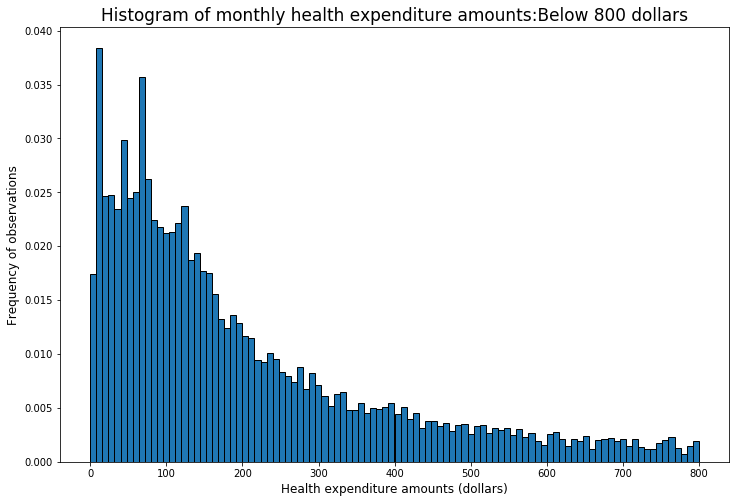

In [553]:
plt.figure(figsize=(12, 8))

weights800 = (1 / clms.shape[0]) * np.ones_like(clms_bl800)

n, bin_cuts, patches = plt.hist(clms_bl800, bins=100, weights=weights800, edgecolor = "k")

plt.title('Histogram of monthly health expenditure amounts:Below 800 dollars', fontsize=17)
plt.xlabel(r'Health expenditure amounts (dollars)', fontsize=12)
plt.ylabel(r'Frequency of observations', fontsize=12)

(b)First, we define the probability density function for gamma distribution. It computes the probability density for each value in monthly health expenditure. Then, we also define log likelihood function and criteria function(negative version of log likelihood function.)

In [554]:
def gamma_dist(xvals, alpha, beta):
    '''
    Compute the probability density of gamma ditribution for data xvals
    given parameters alpha and beta.
    '''
    pdf_vals = ((1 / ((beta ** alpha) * math.gamma(alpha))) *
                (xvals ** (alpha - 1)) * (np.exp(-xvals/beta)))
    return pdf_vals

# Define log likelihood function for the gamma distribution
def log_lik_gamma(xvals, alpha, beta):
    '''
    Compute the log likelihood function for data xvals given gamma
    distribution parameters alpha and beta.
    '''
    pdf_vals = gamma_dist(xvals, alpha, beta)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

def crit(params, *args):
    '''-
    This function computes the negative of the log likelihood function
    given parameters and data. This is the minimization problem version
    of the maximum likelihood optimization problem
    '''
    alpha, beta = params
    xvals = args[0]
    log_lik_val = log_lik_gamma(xvals, alpha, beta)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

Then, we perform maximum likelihood estimation using functions above. Here we minimize the negative log likelihood. The estimated alpha and beta, as well as the maximized log likelihood value are as below.

In [555]:
# Set initial beta and alpha
init_beta = np.var(clms_bl800)/np.mean(clms_bl800)

init_alpha = np.mean(clms_bl800)/init_beta

params_init = np.array([init_alpha, init_beta])
mle_args = clms_bl800
results_uncstr = opt.minimize(crit, params_init, args=mle_args)
alpha_MLE, beta_MLE = results_uncstr.x

print('alpha_MLE=', alpha_MLE, ' beta_MLE=', beta_MLE)
print("Maximized log likelihood: ", log_lik_gamma(clms_bl800, alpha_MLE, beta_MLE))

alpha_MLE= 1.1397568804753377  beta_MLE= 174.86927769810168
Maximized log likelihood:  -56732.59867935801


The implied histogram from gamma distribution derived from estimated parameters is the red line in the plot below. Note that we convert original histrogram with the density scale, as we want to compare the density of distribution. Here we can see that our estimated gamma distribution matches the actual data reasonably, although it seems a little too much reflecting the high desnity in low values.

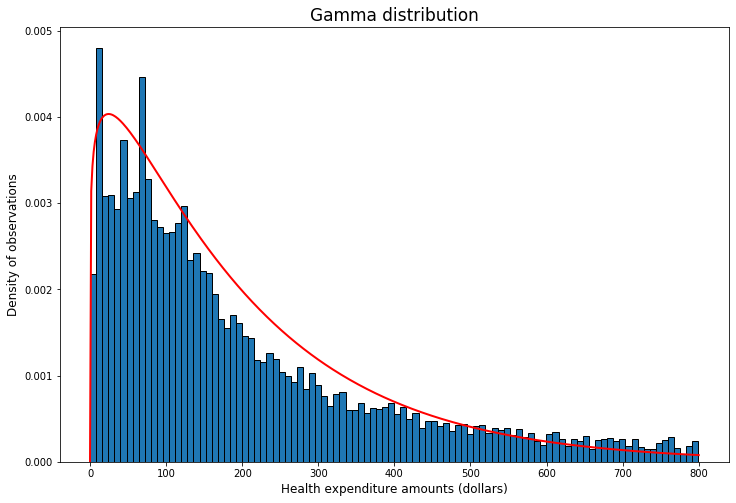

In [556]:
#Plot histgram
plt.figure(figsize=(12, 8))

n_bin = 100
bin_width = 800/n_bin

weights800 = (1 / (clms.shape[0]*bin_width)) * np.ones_like(clms_bl800)

n, bin_cuts, patches = plt.hist(clms_bl800, bins=n_bin, weights=weights800, edgecolor="k")

plt.title('Gamma distribution', fontsize=17)
plt.xlabel(r'Health expenditure amounts (dollars)', fontsize=12)
plt.ylabel(r'Density of observations', fontsize=12)

# Plot smooth line with distribution 1
dist_pts = np.linspace(0, 800, 500)
alpha_1 = alpha_MLE
beta_1 = beta_MLE
plt.plot(dist_pts, gamma_dist(dist_pts, alpha_1, beta_1),
         linewidth=2, color='r')

(c)Similary, we define the probability density function for generalized gamma distribution, as well as the log likelihood function and criteria function(negative version of log likelihood function.)

In [557]:
def gengamma_dist(xvals, alpha, beta, m):
    '''
    Compute the probability density of generalized gamma ditribution for data xvals
    given parameters alpha, beta and m.
    '''
    pdf_vals = (((m/(beta**alpha))/spc.gamma(alpha/m))*\
                (xvals**(alpha-1))*np.exp(-(xvals/beta)**m))
    
    return pdf_vals

def log_lik_gengamma(xvals, alpha, beta, m):
    '''
    Compute the log likelihood function for data xvals given generalized
    gamma distribution parameters alpa, beta and m.
    '''
    pdf_vals = gengamma_dist(xvals, alpha, beta,m)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

def crit(params, *args):
    '''
    This function computes the negative of the log likelihood function
    given parameters and data. This is the minimization problem version
    of the maximum likelihood optimization problem
    '''
    alpha, beta, m = params
    xvals = args[0]
    log_lik_val = log_lik_gengamma(xvals, alpha, beta, m)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

Then, we perform maximum likelihood estimation using functions above. Here we minimize the negative log likelihood. The estimated alpha, beta and m, as well as the maximized log likelihood value are as below. Each parameter does not change huge from the estimates of gammadistribution, and the maximized likelihood slightly improves.

In [558]:
# Set initial beta and alpha
init_alpha = alpha_MLE

init_beta = beta_MLE

init_m = 1

params_init = np.array([init_alpha, init_beta, init_m])
mle_args = clms_bl800
results_uncstr = opt.minimize(crit, params_init, args=mle_args, method='L-BFGS-B', bounds=((1e-10, None), (1e-10, None), (0.1, None)), tol=1e-12)
genalpha_MLE, genbeta_MLE, m = results_uncstr.x
print('genalpha_MLE=', genalpha_MLE, ' genbeta_MLE=', genbeta_MLE, "m_MLE=", m)
print("Maximized log lilelihood: ", log_lik_gengamma(clms_bl800, genalpha_MLE, genbeta_MLE, m))

genalpha_MLE= 1.175381180600684  genbeta_MLE= 156.2457501817754 m_MLE= 0.9499780222577638
Maximized log lilelihood:  -56731.831672441986


The implied histogram from gamma distribution derived from estimated parameters is the black line in the plot below. As the parameters changed slightly, the shape of the distribution is quite similar to gamma distribution.

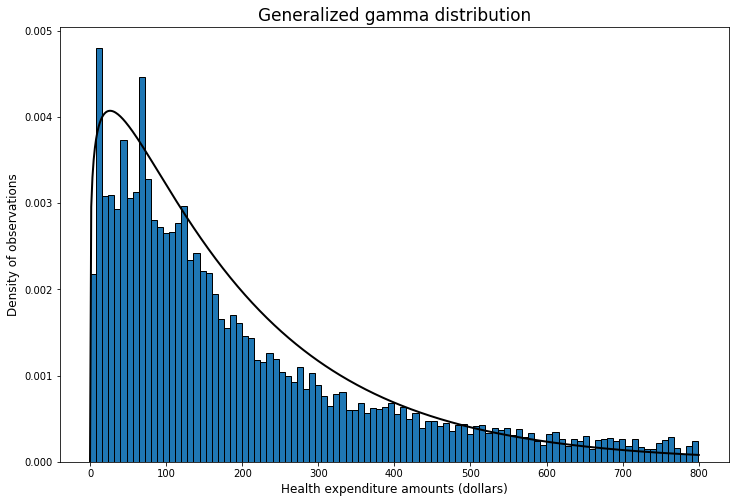

In [559]:
#Plot histgram
%matplotlib inline

plt.figure(figsize=(12, 8))

n_bin = 100
bin_width = 800/n_bin

weights800 = (1 / (clms.shape[0]*bin_width)) * np.ones_like(clms_bl800)

n, bin_cuts, patches = plt.hist(clms_bl800, bins=n_bin, weights=weights800, edgecolor='k')

plt.title('Generalized gamma distribution', fontsize=17)
plt.xlabel(r'Health expenditure amounts (dollars)', fontsize=12)
plt.ylabel(r'Density of observations', fontsize=12)

gen_alpha = genalpha_MLE
gen_beta = genbeta_MLE
gen_m = m
plt.plot(dist_pts, gengamma_dist(dist_pts, gen_alpha, gen_beta, gen_m) ,
         linewidth=2, color='k')

(d)Similary as in previous questions, we define the probability density function for generalized beta 2 distribution. As generalized gamma distribution is the nested one of GB2, we can define it using alpha, beta and m parameters from generalized gamma distribution. We also define the log likelihood function and criteria function(negative version of log likelihood function.)

In [560]:
def gb2_dist(xvals, alpha, beta, m, q):
    '''
    Compute the probability density of generalized beta2 ditribution for data xvals
    given parameters alpha, beta, m and q.
    '''
    pdf_vals = (m*(xvals**(alpha-1))) / ((((q**(1/m))*beta)**alpha) * \
    spc.beta(alpha/m, q) * ((1+(xvals/((q**(1/m))*beta))**m)**(alpha/m +q))) 
    
    pdf_vals[pdf_vals < 1e-10] = 1e-10
    return pdf_vals

def log_lik_gb2(xvals, alpha, beta, m, q):
    '''
    Compute the log likelihood function for data xvals given GB2
    distribution parameters alpa, beta, m and q.
    '''
    pdf_vals = gb2_dist(xvals, alpha, beta,m,q)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    
    return log_lik_val

def crit(params, *args):

    alpha, beta, m,q = params
    xvals = args[0]
    log_lik_val = log_lik_gb2(xvals, alpha, beta, m, q)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

Then, we perform maximum likelihood estimation using functions above. Here we minimize the negative log likelihood. The estimated alpha, beta, m and q, as well as the maximized log likelihood value are as below. Each parameter does not change huge from the estimates of generalized gamma distribution, and the maximized likelihood slightly improves again. This result is reasonable, since generalized gamma distribution is a nested distribution of GB2, and they become converged as q goes to larger value.

In [561]:
# Set initial beta and alpha
init_alpha = genalpha_MLE

init_beta = genbeta_MLE

init_m = m

init_q = 10000

params_init = np.array([init_alpha, init_beta, init_m, init_q])
mle_args = clms_bl800
results_uncstr = opt.minimize(crit, params_init, args=mle_args, method='TNC', bounds=((1e-10, None), (1e-10, None), (1e-10, None), (1e-10, None)), tol=1e-10)
gb2alpha_MLE, gb2beta_MLE, gb2m_MLE, gb2q_MLE = results_uncstr.x
print('gb2alpha_MLE=', gb2alpha_MLE, ' gb2beta_MLE=', gb2beta_MLE, "gb2m_MLE=", gb2m_MLE, "gb2q_MLE=", gb2q_MLE)
print("maximized log likelihood=", log_lik_gb2(clms_bl800, gb2alpha_MLE, gb2beta_MLE, gb2m_MLE, gb2q_MLE))

gb2alpha_MLE= 1.1753811804448113  gb2beta_MLE= 156.2457501816048 gb2m_MLE= 0.9499780222541427 gb2q_MLE= 9999.9999581799
maximized log likelihood= -56731.859800152015


The implied histogram from GB2 distribution derived from estimated parameters is the green line in the plot below. As the parameters changed slightly, the shape of the distribution is quite similar to gamma distribution.

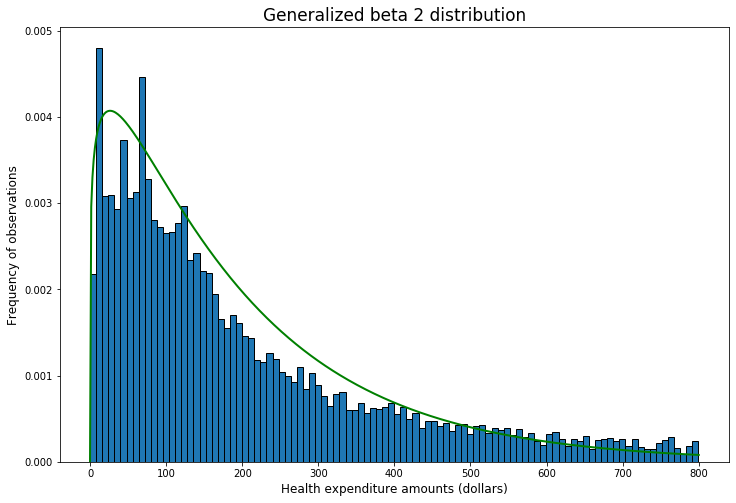

In [562]:
#Plot histgram
plt.figure(figsize=(12, 8))

n_bin = 100
bin_width = 800/n_bin

weights800 = (1 / (clms.shape[0]*bin_width)) * np.ones_like(clms_bl800)

n, bin_cuts, patches = plt.hist(clms_bl800, bins=n_bin, weights=weights800, edgecolor='k')

plt.title('Generalized beta 2 distribution', fontsize=17)
plt.xlabel(r'Health expenditure amounts (dollars)', fontsize=12)
plt.ylabel(r'Frequency of observations', fontsize=12)

gb2_alpha = gb2alpha_MLE
gb2_beta = gb2beta_MLE
gb2_m = gb2m_MLE
gb2_q = gb2q_MLE
plt.plot(dist_pts, gb2_dist(dist_pts, gb2_alpha, gb2_beta, gb2_m, gb2_q) ,
         linewidth=2, color='g')

(e)The two code chunks below are performing log likelihood ratio test for gamma dirtibution and generalized gamma distribution estimates against GB2 estimates, that is, the null hypothesis is that true parameters are ones estimated from GB2. Since we got quite close likelihoods in previous questions for these distributions, the results below show that p-values for chi-squared distribution are quite high for both. Thus, we do not reject the null.

In [564]:
##Likelihood ratio test for gamma distribution against GB2

log_lik_h0 = log_lik_gb2(clms_bl800, gb2alpha_MLE, gb2beta_MLE, gb2m_MLE, gb2q_MLE)
print('hypothesis value log likelihood', log_lik_h0)
log_lik_mle = log_lik_gamma(clms_bl800, alpha_MLE, beta_MLE)
print('MLE log likelihood', log_lik_mle)
LR_val = 2 * (log_lik_mle - log_lik_h0)
print('likelihood ratio value', LR_val)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 4)
print('chi squared of H0 with 4 degrees of freedom p-value = ', pval_h0)

hypothesis value log likelihood -56731.859800152015
MLE log likelihood -56732.59867935801
likelihood ratio value -1.4777584119874518
chi squared of H0 with 4 degrees of freedom p-value =  1.0


In [565]:
##Likelihood ratio test for generalized gamma distribution against GB2

log_lik_h0 = log_lik_gb2(clms_bl800, gb2alpha_MLE, gb2beta_MLE, gb2m_MLE, gb2q_MLE)
print('hypothesis value log likelihood', log_lik_h0)
log_lik_mle = log_lik_gengamma(clms_bl800, genalpha_MLE, genbeta_MLE, gen_m)
print('MLE log likelihood', log_lik_mle)
LR_val = 2 * (log_lik_mle - log_lik_h0)
print('likelihood ratio value', LR_val)
pval_h0 = 1.0 - sts.chi2.cdf(LR_val, 4)
print('chi squared of H0 with 4 degrees of freedom p-value = ', pval_h0)

hypothesis value log likelihood -56731.859800152015
MLE log likelihood -56731.831672441986
likelihood ratio value 0.05625542005873285
chi squared of H0 with 4 degrees of freedom p-value =  0.999611756219713


(f)In order to have the probability that we have more than 1000 dollars health expenditure, we want the probability  density of the GB2 distribution using estimated parameters by MLE. Then we can integrate the pdf to have cdf at x = 1000 and deduct it from 1 so that we have the probability of having expenditure larger than 1000 dollars. Thus, the probability is about 0.5 % here.

In [566]:
# Define pdf function
def compute_prob(xvals):
    '''
    Compute probability density for each value using estimated parameters for GB2
    '''
    return (gb2m_MLE*(xvals**(gb2alpha_MLE-1))) /\
((((gb2q_MLE**(1/gb2m_MLE))*gb2beta_MLE)**gb2alpha_MLE) * \
    spc.beta(gb2alpha_MLE/gb2m_MLE, gb2q_MLE) * \
 ((1+(xvals/((gb2q_MLE**(1/gb2m_MLE))*gb2beta_MLE))**gb2m_MLE)**(gb2alpha_MLE/gb2m_MLE +gb2q_MLE)))

# Integrate pdf to acquire probability and deduct it from 1
1- integrate.quad(compute_prob, 0, 1000)[0]

0.0050847054673666126

## Question2

(a)Load data.

In [567]:
macro = pd.read_csv("MacroSeries.txt", header=None)
macro.columns = ["c_t", "k_t", "w_t", "r_t"]
macro.head()

,c_t,k_t,w_t,r_t
0,1.067109e+07,8.040697e+06,1.059438e+07,0.954120
1,1.169487e+07,7.595072e+06,1.161079e+07,1.107009
2,9.292394e+06,8.323735e+06,9.225588e+06,0.802596
3,7.913165e+06,6.613792e+06,7.856274e+06,0.860176
4,8.140994e+06,5.632136e+06,8.082466e+06,1.039183


First, using equation(3), we can derive $z_t$ as below.


$$ w_t-(1-\alpha)e^{z_t}k_{t}^\alpha = 0 \\ e^{z_t} = \frac{w_t}{(1-\alpha)k_{t}^\alpha} \\ z_t = ln(\frac{w_t}{(1-\alpha)k_{t}^\alpha})  $$

Then, we define pdf function for $z_t$. We can derive the distribution of $z_t$ using equation(5).

In [568]:
def norm_dist(k, w, alpha, mu, sigma, p):
    '''
    Calculate pdf values of z_t using equation(3) and (5)
    '''
    # Derive z_t values using equation(3)
    z_t = np.log(w/((1-alpha)*k**alpha))
    
    z_vec = np.empty(101)
    
    # z_0 = mu
    z_vec[0] = mu
    
    # Derive probability distribution of z using equation(4)
    for i in range(1, len(z_vec)):
        z_vec[i] = sts.norm.pdf(z_t[i-1], p*z_vec[i-1]+(1-p)*mu, sigma)
    
    # We want probability of z only in t=1:100
    pdf_vals = z_vec[1:100]
    
    return pdf_vals

Then, we define log_likelihood function and criteria function similary as in the precvious question.

In [569]:
def log_lik_norm(k, w, alpha, mu, sigma, p):
    
    pdf_vals = norm_dist(k, w, alpha, mu, sigma, p)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    return log_lik_val

def crit(params, *args):
    
    alpha, mu, sigma, p = params
    k, w = args
    log_lik_val = log_lik_norm(k, w, alpha, mu, sigma, p)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

Now we perform MLE estimation. We set initial $alpha$ and $p$ as the center of their constraint and $mu$, $sigma$ as 1. The estimated parameters, maximum log likelihood and hessian variance-covariance matrix of estmates are as below.

In [570]:
# Set initial parameters

init_alpha = 0.5

init_mu = 1

init_sigma = 1 

init_p = 0

k = macro.k_t
w = macro.w_t

params_init = np.array([init_alpha, init_mu, init_sigma, init_p])
mle_args = (k, w)
results_uncstr = opt.minimize(crit, params_init, args=(mle_args), method='L-BFGS-B', bounds=((0, 1), (0, None), (0, None), (-1, 1)))
alpha_MLE, mu_MLE, sigma_MLE, p_MLE = results_uncstr.x
print('alpha_MLE=', alpha_MLE, ' mu_MLE=', mu_MLE, "sigma_MLE=", sigma_MLE, "p_MLE=", p_MLE)
print("maximized log likelihood=", log_lik_norm(k, w, alpha_MLE, mu_MLE, sigma_MLE, p_MLE))
print("Hessian variance-covariance matrix of estimates: ")
print(results_uncstr.hess_inv.todense())

alpha_MLE= 0.5900035859621249  mu_MLE= 1.1335011186839563 sigma_MLE= 1.9902055455210113 p_MLE= -0.008179080219282556
maximized log likelihood= -697.4296858266736
Hessian variance-covariance matrix of estimates: 
[[ 0.45836377 -0.15425228 -0.99684803  0.04033791]
 [-0.15425228  1.03281336  0.20918813  0.00923363]
 [-0.99684803  0.20918813  2.20746266  0.05833419]
 [ 0.04033791  0.00923363  0.05833419  0.99712217]]


(b) Similary as in (a), we can derive $z_t$ using equation(4) as below.

$$ r_t-\alpha e^{z_t}k_{t}^{\alpha-1} = 0 \\ e^{z_t} = \frac{r_t}{\alpha k_{t}^{\alpha-1}} \\ z_t = ln(\frac{r_t}{\alpha k_{t}^{\alpha-1}})  $$

Then, we define pdf function for $z_t$. We can derive the distribution of $z_t$ using equation(5). We also define log likelihood function as well as criteria function.

In [571]:
def norm_dist2(k, r, alpha, mu, sigma, p):
    '''
    Calculate pdf values of z_t using equation(4) and (5)
    '''
    # Derive z_t values using equation(4)
    z_t = np.log(r/(alpha*(k**(alpha-1))))
    
    z_vec = np.empty(101)
    
    # z_0 = mu
    z_vec[0] = mu
    
    # Derive probability distribution of z using equation(4)
    for i in range(1, len(z_vec)):
        z_vec[i] = sts.norm.pdf(z_t[i-1], p*z_vec[i-1]+(1-p)*mu, sigma)
    
    # We want probability of z only in t=1:100
    pdf_vals = z_vec[1:100]
    return pdf_vals

def log_lik_norm2(k, r, alpha, mu, sigma, p):
   
    pdf_vals = norm_dist2(k, r, alpha, mu, sigma, p)
    ln_pdf_vals = np.log(pdf_vals)
    log_lik_val = ln_pdf_vals.sum()
    return log_lik_val

def crit(params, *args):
    
    alpha, mu, sigma, p = params
    k, r = args
    log_lik_val = log_lik_norm2(k, r, alpha, mu, sigma, p)
    neg_log_lik_val = -log_lik_val
    
    return neg_log_lik_val

Again we perform MLE estimation similary as in the previous question. The estimated parameters, maximum log likelihood and hessian variance-covariance matrix of estmates are as below.

In [572]:
# Set initial parameters
init_alpha = 0.5

init_mu = 1

init_sigma = 1 

init_p = 0.1

k = macro.k_t
r = macro.r_t

params_init = np.array([init_alpha, init_mu, init_sigma, init_p])
mle_args = (k, r)
results_uncstr = opt.minimize(crit, params_init, args=(mle_args), method='L-BFGS-B', bounds=((0, 1), (0, None), (0, None), (-1, 1)))
alpha2_MLE, mu2_MLE, sigma2_MLE, p2_MLE = results_uncstr.x
print('alpha2_MLE=', alpha2_MLE, ' mu2_MLE=', mu2_MLE, "sigma2_MLE=", sigma2_MLE, "p2_MLE=", p2_MLE)
print("maximized log likelihood=", log_lik_norm(k, r, alpha2_MLE, mu2_MLE, sigma2_MLE, p2_MLE))
print("Hessian variance-covariance matrix of estimates: ")
print(results_uncstr.hess_inv.todense())

alpha2_MLE= 0.9808603931145315  mu2_MLE= 1.0461158850115788 sigma2_MLE= 1.1320433792331888 p2_MLE= 0.06037241730798295
maximized log likelihood= -6155.518639525243
Hessian variance-covariance matrix of estimates: 
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]


(c)First, using equation(4), we acquire z_st. Then, as z is distributed normally with mean of 10*p+(1-p)*mu +e and sigma as sigma_MLE, we can calculate the probability that z becomes equal or smaller than z_st. Thus, the probability that r_t becomes larger than 1 is calculated as below.(0.1%)

In [574]:
z_st = np.log(1/(alpha_MLE*(7500000)**(alpha_MLE-1)))

mu = 10*p_MLE+(1-p_MLE)*mu_MLE

1 - sts.norm.cdf(z_st, loc=mu, scale=sigma_MLE)

0.0013804008763659281